Find the 

# Table of Contents
 <p><div class="lev2"><a href="#Base-Criteria"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Base Criteria</a></div><div class="lev3"><a href="#Existing-climate-for-vacation-rentals:"><span class="toc-item-num">0.1.1&nbsp;&nbsp;</span>Existing climate for vacation rentals:</a></div><div class="lev2"><a href="#Add-seasonal-data"><span class="toc-item-num">0.2&nbsp;&nbsp;</span>Add seasonal data</a></div><div class="lev2"><a href="#Basis-for-proximity"><span class="toc-item-num">0.3&nbsp;&nbsp;</span>Basis for proximity</a></div><div class="lev4"><a href="#Plot-where-the-current-locations-are."><span class="toc-item-num">0.3.0.1&nbsp;&nbsp;</span>Plot where the current locations are.</a></div><div class="lev3"><a href="#Investment:"><span class="toc-item-num">0.3.1&nbsp;&nbsp;</span>Investment:</a></div><div class="lev3"><a href="#Revenue-(Price-to-Rent)"><span class="toc-item-num">0.3.2&nbsp;&nbsp;</span>Revenue (Price to Rent)</a></div><div class="lev3"><a href="#Home-Price"><span class="toc-item-num">0.3.3&nbsp;&nbsp;</span>Home Price</a></div><div class="lev2"><a href="#Renters"><span class="toc-item-num">0.4&nbsp;&nbsp;</span>Renters</a></div><div class="lev2"><a href="#Base-Analysis"><span class="toc-item-num">0.5&nbsp;&nbsp;</span>Base Analysis</a></div><div class="lev2"><a href="#Where-are-they-located?"><span class="toc-item-num">0.6&nbsp;&nbsp;</span>Where are they located?</a></div><div class="lev2"><a href="#Key-Takeaways"><span class="toc-item-num">0.7&nbsp;&nbsp;</span>Key Takeaways</a></div><div class="lev2"><a href="#Above-a-certain-population"><span class="toc-item-num">0.8&nbsp;&nbsp;</span>Above a certain population</a></div><div class="lev2"><a href="#Why-is-Everything-in-South-Florida?"><span class="toc-item-num">0.9&nbsp;&nbsp;</span>Why is Everything in South Florida?</a></div><div class="lev2"><a href="#Near-a-coastline"><span class="toc-item-num">0.10&nbsp;&nbsp;</span>Near a coastline</a></div><div class="lev2"><a href="#Near-Major-Airport"><span class="toc-item-num">0.11&nbsp;&nbsp;</span>Near Major Airport</a></div><div class="lev3"><a href="#Accessibility:"><span class="toc-item-num">0.11.1&nbsp;&nbsp;</span>Accessibility:</a></div>

## Base Criteria
1. **Growth:** Have property values in the region historically gone up?
2. **Revenue:** Can rent as a short-term vacation rental? And do households in the region generate sizeable short-term rental rates?
3. **Value:** Is the house in an affordable area?
4. **Existing Climate:** Are there other vacation rentals in the region?
5. **Vacation Friendly:** Is it near vacation activities, like ski resorts, lakes, beaches, etc?
6. **Accessible:** Is it a near major airport? This is especially important if the house is across country from the owner.



In [71]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm  

from matplotlib.patches import Circle, Rectangle, Arc
from geopy.geocoders import Nominatim
from descartes import PolygonPatch
from pyproj import Proj, transform
import json
from shapely.geometry import mapping, shape, LineString, Point


import seaborn as sb  
sb.set_style('darkgrid')



In [72]:

def plot_polygon(ax, coordlist, edgecolor, color='white', alpha=0.5):    
    poly = {"type": "Polygon", "coordinates": coordlist}
    ax.add_patch(PolygonPatch(poly, facecolor='white', edgecolor='black', linewidth=1.0, alpha=alpha))
    ax.plot(coordlist[:, 0],coordlist[:, 1], color='w')


def plot_multipolygon(ax, geom, color='red'):
    """ Can safely call with either Polygon or Multipolygon geometry
    change from original
    """
    if geom['type'] == 'Polygon':
        a = np.asarray(geom['coordinates'])
        plot_polygon(ax, a, color)
    elif geom['type'] == 'MultiPolygon':
         for g in geom['coordinates']:
            a = np.asarray(g)
            plot_polygon(ax, a, color)


In [79]:
def add_us_outline(ax):
    with open('data/us_states.geojson') as data_file:    
        data = json.load(data_file)
        
    for feature in data['features']:
        plot_multipolygon(ax, feature['geometry'], color='black')
    
    #set the graph axes to the feature extents
    ax.set_xlim(-160.6708333, -65.9038889)
    ax.set_ylim(18.0638889, 50.0002778)
    

Zillow  Home value time series data for US cities http://files.zillowstatic.com/research/public/Zip/Zip_Zhvi_AllHomes.csv

In [124]:
df = pd.read_csv('data/City_Zhvi_AllHomes.csv')


10919

Zillow Price to Rent Ratio Time Series Data for US cities- http://files.zillowstatic.com/ 

In [125]:
df_price_2_rent = pd.read_csv('data/City_PriceToRentRatio_AllHomes.csv')


10919

### Existing climate for vacation rentals:
Area with vacation rentals? Analyze only cities that are in a county where more than 20% of the households are for recreational use.

In [122]:
df['CountyState'] = df['CountyName'] + " County, " + df['State']

df_price_2_rent['CityState'] = df_price_2_rent['RegionName'] + ', ' + df_price_2_rent['State']

# join on the combination of the city and state as there are multiple Hollywoods

df['CityState'] = df['RegionName'] + ', ' + df['State']
new_df = pd.merge(df, df_price_2_rent, on='CityState', how='inner')


11383

## Add seasonal data

10401

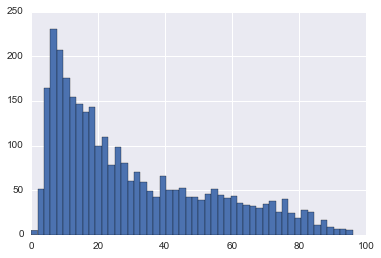

In [121]:
## Vacation or not occupied
xl = pd.ExcelFile('data/seasonal_rates.csv')
df_seasonal = xl.parse('seasonal_rates.csv')
plt.hist(df_seasonal['seasonal use'], bins=50)


# df_seasonal = df_seasonal[df_seasonal['seasonal use'] > 20.0]

df_seasonal['CountyState'] = df_seasonal['Geographic area'] + ', ' + df_seasonal['State Abbr']
seasonal_df = pd.merge(new_df, df_seasonal, on='CountyState', how='inner')
len(seasonal_df)

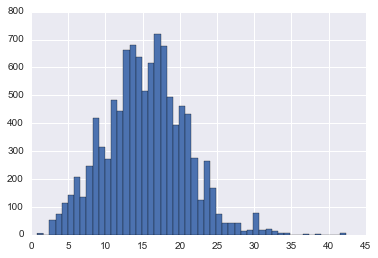

In [77]:
plt.hist(seasonal_df['For sale only'], bins=50);

## Basis for proximity
If you are buying a vacation home, proximity to attractions is important. I included a lat/long to check for reference.

Data: US cities with population and latitude and longitude https://www.maxmind.com/en/free-world-cities-database



In [78]:
# add geo location
df_geo = pd.read_csv('data/us_cities.csv')

# combine the city and state for merging
df_geo['CityState'] = df_geo['AccentCity'] + ', ' + df_geo['Region']
df_geo = pd.merge(seasonal_df, df_geo, on='CityState', how='inner')

#### Plot where the current locations are.

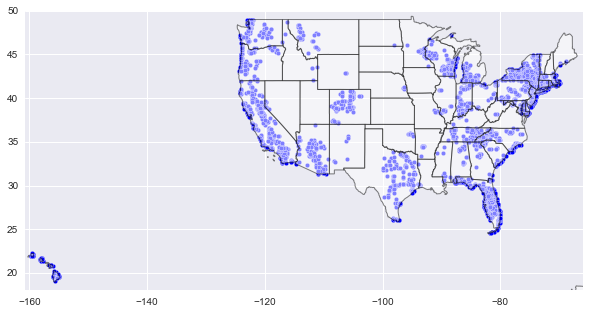

In [118]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_geo['Longitude'], df_geo['Latitude'], marker='o', edgecolor='w');
df_geo.to_csv('out.csv')

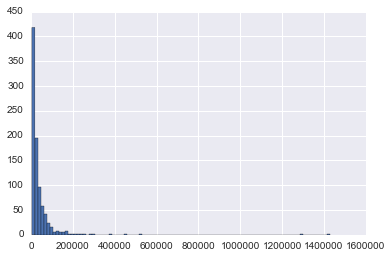

In [119]:
plt.hist(df_geo['Population'].dropna(), bins=100);

### Investment: 
looking for upward trending growth in the value of the homes

In [82]:
df_geo['growth'] = (df_geo['2016-03_x'] - df_geo['2011-03_x']) / df_geo['2011-03_x']

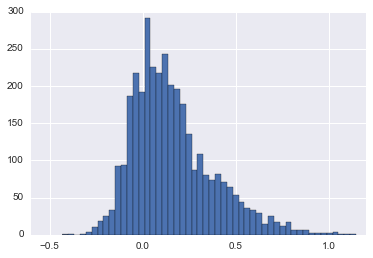

In [120]:
plt.hist(df_geo['growth'].dropna(), bins=50);

In [84]:
# calculate growth

max_growth, min_growth = max(df_geo['growth']), min(df_geo['growth'])
difference = max_growth - min_growth

df_geo['growth_index'] = 100*(df_geo['growth'] - min_growth) / difference


### Revenue (Price to Rent)
The Price to Rent Ratio is the median ratio between a home's value and annualized rent.

It would be great to have this for the annual rate for investment

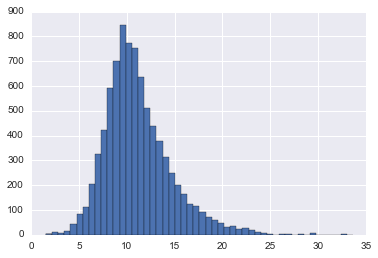

In [85]:
plt.hist(df_geo['2016-03_y'].dropna(), bins=50);

In [86]:
max_revenue, min_revenue = max(df_geo['2016-03_y']), min(df_geo['2016-03_y'])
difference = max_revenue - min_revenue

df_geo['revenue_index'] = 100*(max_revenue - df_geo['2016-03_y']) / difference

df_geo['old_revenue_index'] = 100*(df_geo['2016-03_y'] - min_revenue) / difference

# df_geo[['revenue_index', '2016-03_y']].sort('revenue_index', ascending=False)


### Home Price
The lower the price the higher the index.

The median home value is $169000.0


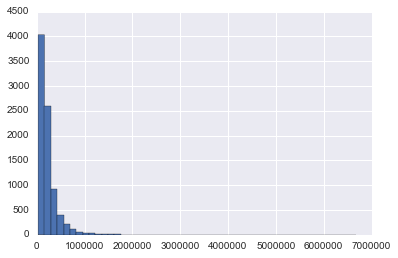

In [87]:
plt.hist(df_geo['2016-03_x'], bins=50);
print("The median home value is $" + str(df_geo['2016-03_x'].median()))

In [88]:
max_price, min_price = max(df_geo['2016-03_x']), min(df_geo['2016-03_x'])
difference = max_price - min_price
df_geo['price_index'] = 100*(max_price - df_geo['2016-03_x'] ) / difference


## Renters


the percentage of renters in the area.

In [89]:
min_seasonal, max_seasonal = min(df_geo['seasonal use']), max(df_geo['seasonal use'])
difference = max_seasonal - min_seasonal
df_geo['env_index'] = 100*(df_geo['seasonal use'] - min_seasonal) / difference


## Base Analysis
Subsequent analysis will use this the analysis as the basis and focus on regions

In [90]:
df_geo['index'] = (.30 * df_geo['growth_index']) + (.30 * df_geo['price_index']) + (.30 * df_geo['revenue_index']) + (.10 * df_geo['env_index'])


# sort descending from the highest index down and limit the top 10
df_out = df_geo.sort('index', ascending=False).head(10)
df_out['Home Value in USD'] = df_out['2016-03_x']
df_out['Price to Rent'] = df_out['2016-03_y']
df_out['growth rate (5 years)'] = df_out['growth'].apply(lambda x: str("%.2f" % (x * 100)) + " %")
df_out['monthly rent'] = (df_out['2016-03_x'] / df_out['2016-03_y']).apply(lambda x: int(x / 12))

df_out[['RegionName_x', 'State_x', 'index', 'Population', 'Home Value in USD', 'Price to Rent', 'growth rate (5 years)', 'monthly rent','seasonal use']]


,RegionName_x,State_x,index,Population,Home Value in USD,Price to Rent,growth rate (5 years),monthly rent,seasonal use
1437,Lehigh Acres,FL,86.148716,48534,126900,9.26,114.72 %,1142,55.8
5571,Golden Gate,FL,85.933024,25388,202600,8.40,102.80 %,2009,69.4
1525,Golden Lakes,FL,83.505419,NaN,70000,5.09,79.95 %,1146,50.0
1517,Palm Springs,FL,83.336956,14329,124800,7.87,95.00 %,1321,50.0
4095,Kensington Park,FL,83.121668,NaN,158600,9.03,95.08 %,1463,59.5
658,Leisure City,FL,82.661397,23770,136600,7.49,100.59 %,1519,31.4
4425,Yeehaw Junction,FL,81.276911,24080,158500,10.45,93.29 %,1263,57.6
4426,Poinciana,FL,81.054447,NaN,132400,9.82,88.07 %,1123,57.6
1929,Broadview Park,FL,81.009600,NaN,158300,8.18,87.78 %,1612,44.3
1920,North Lauderdale,FL,80.975046,34267,143200,7.90,85.73 %,1510,44.3


## Where are they located?


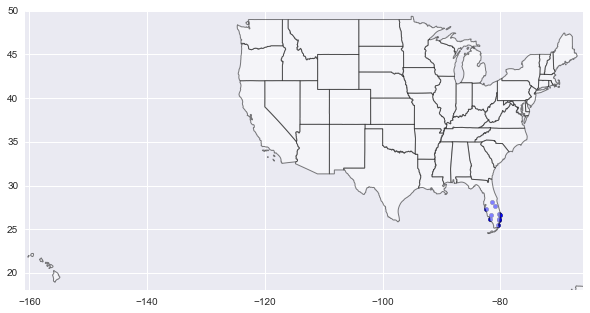

In [91]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_out['Longitude'], df_out['Latitude'], marker='o');



## Key Takeaways

1. A lot of small towns
2. price to rent is not the best since these would most likely be short term rentals. 
3. everything is in South Florida near but not in major metropolitan areas -- Tampa, Orlando, Miami/Fort Lauderdale
4. Why is Leigh Acres so desirable? (http://www.huffingtonpost.com/raymond-schillinger/lehigh-acres-florida-a-pa_b_817783.html)


## Above a certain population
I have not heard of these cities. Find cities with populations above 100K

In [92]:
# sort descending from the highest index down and limit the top 10


df_out = df_geo[df_geo['Population'] > 100000].sort('index', ascending=False).head(10)

df_out[['RegionName_x', 'State_x', 'Population', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']]

,RegionName_x,State_x,Population,index,2016-03_x,2016-03_y,growth,seasonal use
1436,Cape Coral,FL,130807,77.971541,200200,11.03,0.798742,55.8
1371,San Bernardino,CA,202381,74.532503,223300,13.55,0.845455,38.7
1906,Hollywood,FL,144821,74.503549,220000,10.45,0.646707,44.3
2433,Richmond,CA,103041,74.081780,397400,15.02,1.114955,9.6
1312,Saint Petersburg,FL,246316,73.298085,156100,10.10,0.542490,44.6
1074,Moreno Valley,CA,168629,72.577724,269200,14.17,0.746918,44.2
631,Hialeah,FL,224840,72.528938,184900,8.87,0.520559,31.4
238,Glendale,AZ,240112,72.123423,192500,13.32,0.753188,28.1
1905,Pembroke Pines,FL,155862,72.082024,253500,10.87,0.541033,44.3
1907,Miramar,FL,112922,72.034339,237200,10.48,0.513720,44.3


## Why is Everything in South Florida?


What is the trend in the home values? South Florida was hit hard by the recession/housing market crisis. What has happened since.

In [93]:
year_lst = ['1996-04', '1996-05', '1996-06', '1996-07', '1996-08', '1996-09', '1996-10', '1996-11', '1996-12', '1997-01', '1997-02', '1997-03', '1997-04', '1997-05', '1997-06', '1997-07', '1997-08', '1997-09', '1997-10', '1997-11', '1997-12', '1998-01', '1998-02', '1998-03', '1998-04', '1998-05', '1998-06', '1998-07', '1998-08', '1998-09', '1998-10', '1998-11', '1998-12', '1999-01', '1999-02', '1999-03', '1999-04', '1999-05', '1999-06', '1999-07', '1999-08', '1999-09', '1999-10', '1999-11', '1999-12', '2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06', '2000-07', '2000-08', '2000-09', '2000-10', '2000-11', '2000-12', '2001-01', '2001-02', '2001-03', '2001-04', '2001-05', '2001-06', '2001-07', '2001-08', '2001-09', '2001-10', '2001-11', '2001-12', '2002-01', '2002-02', '2002-03', '2002-04', '2002-05', '2002-06', '2002-07', '2002-08', '2002-09', '2002-10', '2002-11', '2002-12', '2003-01', '2003-02', '2003-03', '2003-04', '2003-05', '2003-06', '2003-07', '2003-08', '2003-09', '2003-10', '2003-11', '2003-12', '2004-01', '2004-02', '2004-03', '2004-04', '2004-05', '2004-06', '2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12', '2005-01', '2005-02', '2005-03', '2005-04', '2005-05', '2005-06', '2005-07', '2005-08', '2005-09', '2005-10', '2005-11', '2005-12', '2006-01', '2006-02', '2006-03', '2006-04', '2006-05', '2006-06', '2006-07', '2006-08', '2006-09', '2006-10', '2006-11', '2006-12', '2007-01', '2007-02', '2007-03', '2007-04', '2007-05', '2007-06', '2007-07', '2007-08', '2007-09', '2007-10', '2007-11', '2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05', '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11', '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05', '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11', '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05', '2010-06', '2010-07', '2010-08', '2010-09', '2010-10_x','2010-11_x', '2010-12_x', '2011-01_x', '2011-02_x', '2011-03_x', '2011-04_x', '2011-05_x', '2011-06_x', '2011-07_x', '2011-08_x', '2011-09_x', '2011-10_x', '2011-11_x', '2011-12_x', '2012-01_x', '2012-02_x', '2012-03_x', '2012-04_x', '2012-05_x', '2012-06_x', '2012-07_x', '2012-08_x', '2012-09_x', '2012-10_x', '2012-11_x', '2012-12_x', '2013-01_x', '2013-02_x', '2013-03_x', '2013-04_x','2013-05_x', '2013-06_x', '2013-07_x', '2013-08_x', '2013-09_x', '2013-10_x', '2013-11_x', '2013-12_x', '2014-01_x', '2014-02_x', '2014-03_x', '2014-04_x', '2014-05_x', '2014-06_x', '2014-07_x', '2014-08_x', '2014-09_x', '2014-10_x', '2014-11_x', '2014-12_x', '2015-01_x', '2015-02_x', '2015-03_x', '2015-04_x', '2015-05_x', '2015-06_x', '2015-07_x', '2015-08_x', '2015-09_x', '2015-10_x', '2015-11_x', '2015-12_x', '2016-01_x', '2016-02_x', '2016-03_x']

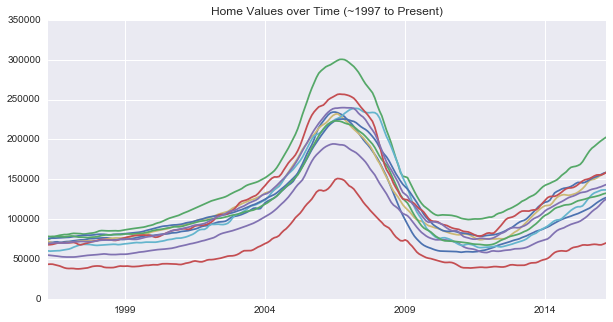

In [94]:
for index, row in df_geo.sort('index', ascending=False).head(10).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)
    
    over_time.plot(figsize=(10, 5), title="Home Values over Time (~1997 to Present)");

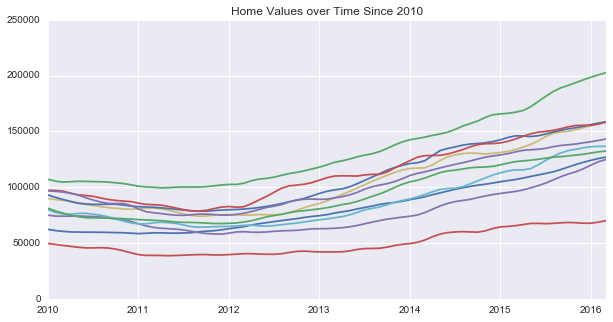

In [95]:


for index, row in df_geo.sort('index', ascending=False).head(10).iterrows():
    
    start_month = int(year_lst[0].split("-")[1])
    start_year = int(year_lst[0].split("-")[0])
    date_range = pd.date_range(start=pd.datetime(start_year, start_month, 1), periods=len(year_lst), freq='M')
    over_time = pd.Series(row[year_lst].tolist(),index=date_range)

    recent_dates = over_time[over_time.index.year >= 2010]
    recent_dates.plot(figsize=(10, 5), title="Home Values over Time Since 2010");
    

What is the rolling average for growth since recession in South Florida? How do we know that South Florida is not doomed to repeat the problem?

In [96]:
# df_foreclosure = pd.read_csv('data/City_HomesSoldAsForeclosures-Ratio_AllHomes.csv')



# df_foreclosure = df_foreclosure.rename(columns=lambda x: x + "_f")
# df_foreclosure['CityState'] = df_foreclosure['RegionName_f'] + ', ' + df_foreclosure['State_f']

# # df_foreclosure = df_foreclosure.drop(['RegionID_f', 'RegionName_f', 'State_f', 'Metro_f', 'CountyName_f', 'SizeRank_f'],inplace=True,axis=1)

# df_geo = pd.merge(df_geo, df_foreclosure, on='CityState', how='inner')

# df_geo.to_csv('data.csv')

In [97]:
# fore_year_lst_ = [ str(j) + "-0" + str(k) + "_f" if k < 10 else str(j) + "-" + str(k) + "_f" for j in range(1997,2016)  for k in range(1,13)]

# plt.hist(df_geo['2009-09_f'].dropna(), bins=50);

# # df_geo['2009-09_f'].median()

In [98]:
# plt.hist(df_geo['2015-09_f'].dropna(), bins=50);

# df_geo['2015-09_f'].median()

## Near a coastline


In [99]:
        
def convert_lines():
    with open('data/us_coastlines.geojson') as data_file:    
        data = json.load(data_file)
            
    point_to_line={}
    count = 0

    for feature in data['features']:
        
        feature_name = feature['properties']['NAME'] +" "+ feature['properties']['MTFCC']
        

        if feature_name not in ['Arctic', 'Caribe' ]:
            geom = feature['geometry']['coordinates']
            coordlist = np.asarray(geom)
            x, y = transform(wgs84, cap, coordlist[:, 0],coordlist[:, 1])
            
            line = LineString(zip(x, y))

            point_to_line[str(count) + " " + feature_name]=line
            count+=1
            
    return point_to_line

def measure_distance(points_to_line):
    lines = []
    oceans = []
    cities = []
    
    for index, row in df_geo.iterrows():
        p = Point(row['x_feet'],row['y_feet'])
  
        near_shore = False
        ocean_name = None
    
        
        for name in points_to_line:
            line = points_to_line[name]
            dist = p.distance(line)
            
            if dist < (5280 * 10):
                near_shore = True
                ocean_name = name
                break
        
        lines.append(near_shore)
        oceans.append(ocean_name)
        cities.append(row['CityState'])
    return lines, oceans, cities
                
                    
               
# points_to_line = convert_lines()

# lines, oceans, cities = measure_distance(points_to_line)

# coast_df = pd.DataFrame({'cities' : cities,
#  'lines' : lines,
#  'oceans': oceans
#   })

# coast_df.to_csv('close2oceans.csv')



IndentationError: expected an indented block (<ipython-input-99-f0f22766750e>, line 4)

In [100]:
# merge the files together

coast_df = pd.read_csv('close2oceans.csv')

coast_df['CityState'] = coast_df['cities']
df_geo = pd.merge(df_geo, coast_df, on='CityState', how='inner')

In [111]:
df_out = df_geo[df_geo['lines'] == True]
df_out['ocean name'] = df_out['oceans'].apply(lambda x: x.split(' ')[1])
df_out = df_out[['RegionName_x', 'State_x','ocean name', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']].sort('index', ascending=False).head(10)
df_out

,RegionName_x,State_x,ocean name,index,2016-03_x,2016-03_y,growth,seasonal use
1903,Golden Gate,FL,Gulf,85.933024,202600,8.40,1.028028,69.4
364,Golden Lakes,FL,Atlantic,83.505419,70000,5.09,0.799486,50.0
356,Palm Springs,FL,Atlantic,83.336956,124800,7.87,0.950000,50.0
1105,Kensington Park,FL,Gulf,83.121668,158600,9.03,0.950800,59.5
106,Leisure City,FL,Atlantic,82.661397,136600,7.49,1.005874,31.4
485,Broadview Park,FL,Atlantic,81.009600,158300,8.18,0.877817,44.3
476,North Lauderdale,FL,Atlantic,80.975046,143200,7.90,0.857328,44.3
131,Naranja,FL,Atlantic,80.963786,157700,8.50,0.968789,31.4
1098,North Sarasota,FL,Gulf,79.780089,128800,7.71,0.685864,59.5
3472,Laurium,MI,Great,79.652994,71600,7.30,0.623583,62.7


It is just like the one above. 

What about for California.

In [114]:
import warnings
warnings.filterwarnings('ignore')

df_out = df_geo[(df_geo['lines'] == True) & (df_geo['State_x'] == 'CA')]
df_out['ocean name'] = df_out['oceans'].apply(lambda x: x.split(' ')[1])
df_out[['RegionName_x', 'State_x','ocean name', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']].sort('index', ascending=False)


,RegionName_x,State_x,ocean name,index,2016-03_x,2016-03_y,growth,seasonal use
792,Boulder Creek,CA,Pacific,69.845936,499300,16.34,0.698877,55.4
789,Watsonville,CA,Pacific,69.360017,471200,15.91,0.641812,55.4
438,Salinas,CA,Pacific,68.915325,386500,16.01,0.695919,39.4
558,Guadalupe,CA,Pacific,68.254704,238700,13.32,0.528169,31.3
414,Guerneville,CA,Pacific,68.160935,369800,14.84,0.560338,44.0
36,National City,CA,Pacific,68.032306,355000,15.23,0.672950,26.7
420,Monte Rio,CA,Pacific,66.846068,351500,14.76,0.477512,44.0
796,Felton,CA,Pacific,65.830678,524700,16.74,0.500429,55.4
795,Ben Lomond,CA,Pacific,65.754377,608200,17.92,0.579330,55.4
1277,Oceano,CA,Pacific,65.548792,390500,17.28,0.447905,60.6


## Near Major Airport

### Accessibility: 
Is it near a major airport? Find cities that are within at least 20 miles of major commercial airport.

In [102]:
# Load Airport Data
df_airports = pd.read_csv('data/us_airports.csv')

# There are airports in every little town.
# remove non major airports

major_airports_codes = ["GA","LAX","ORD","DFW","JFK","DEN","SFO","CLT","LAS","PHX","IAH","MIA","SEA","EWR","MCO","MSP","DTW","BOS","PHL","LGA","FLL","BWI","IAD","MDW","SLC","DCA","HNL","SAN","TPA","PDX","STL","HOU","BNA","AUS","OAK","MCI","MSY","RDU","SJC","SNA","DAL","SMF","SJU","SAT","RSW","PIT","CLE","IND","MKE","CMH","OGG","PBI","BDL","CVG","JAX","ANC","BUF","ABQ","ONT","OMA","BUR"]

df_airports = df_airports[df_airports['code'].isin(major_airports_codes)]

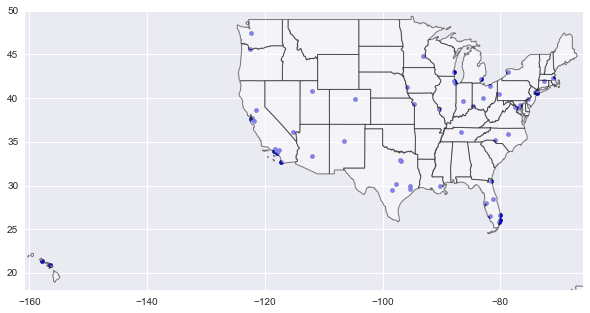

In [103]:
# Sanity Check
# make sure airports are in parts of the states that make sense
# validate that the data is correct (lat, lons for airports fall on the map)

fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_airports['lon'], df_airports['lat'], marker='o');

In [104]:
#converted units
cap = Proj('+datum=NAD83 +lat_0=32.10 +lat_1=33.53 '
    '+lat_2=32.47 +lon_0=-116.15 +no_defs +proj=lcc +units=us-ft '
    '+x_0=2000000 +y_0=500000', preserve_units=True)

wgs84 = Proj(init='epsg:4326')

def transform_lat_lon(row):
 
    try:
        x, y = transform(wgs84, cap, row['Longitude'], row['Latitude'])
        return x,y
    except:
        return np.nan 

def transform_lat_lon2(row):

    try:
        x, y = transform(wgs84, cap, row['lon'], row['lat'])
        return x,y
    except:
        return np.nan 
    
    
# gett city geo    
df_geo['x_feet'], df_geo['y_feet'] = zip(*df_geo.apply(transform_lat_lon, axis=1).tolist())

df_airports['x_feet'], df_airports['y_feet'] = zip(*df_airports.apply(transform_lat_lon2, axis=1).tolist())


In [105]:
import math
feet_to_mile = 5280.0
radius = 25

def check_location(row):
    center_x, center_y = row['x_feet'], row['y_feet']
    airport_close = False
    
    for index, airport in df_airports.iterrows():
        x, y = airport['x_feet'], airport['y_feet'] 
        eucl_dist = math.sqrt((x - center_x) ** 2 + (y - center_y) ** 2) / feet_to_mile
        if eucl_dist < radius:
            airport_close = True
            break
    
    return airport_close


df_geo['near_airport'] = df_geo.apply(check_location, axis=1)    


In [106]:


df_geo_near_airport = df_geo[df_geo['near_airport'] == True]

# sort descending from the highest index down and limit the top 10

df_out = df_geo_near_airport.sort('index', ascending=False).head(10)
df_out[['RegionName_x', 'State_x','Population', 'index', '2016-03_x', '2016-03_y', 'growth', 'seasonal use']].head(10)


,RegionName_x,State_x,Population,index,2016-03_x,2016-03_y,growth,seasonal use
335,Lehigh Acres,FL,48534,86.148716,126900,9.26,1.147208,55.8
1903,Golden Gate,FL,25388,85.933024,202600,8.40,1.028028,69.4
364,Golden Lakes,FL,NaN,83.505419,70000,5.09,0.799486,50.0
356,Palm Springs,FL,14329,83.336956,124800,7.87,0.950000,50.0
106,Leisure City,FL,23770,82.661397,136600,7.49,1.005874,31.4
1288,Poinciana,FL,NaN,81.054447,132400,9.82,0.880682,57.6
485,Broadview Park,FL,NaN,81.009600,158300,8.18,0.877817,44.3
476,North Lauderdale,FL,34267,80.975046,143200,7.90,0.857328,44.3
131,Naranja,FL,NaN,80.963786,157700,8.50,0.968789,31.4
24,Youngtown,AZ,NaN,80.624740,110900,9.62,1.016364,28.1


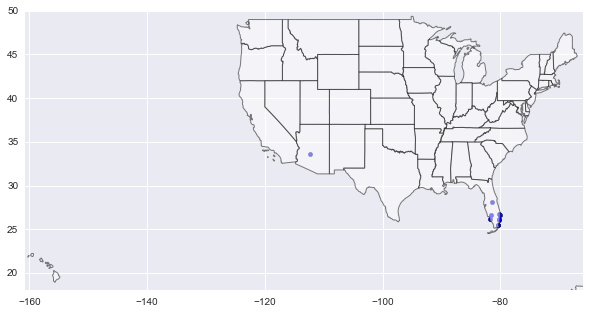

In [107]:
fig = plt.figure(figsize=(10,5))
ax = plt.gca()
add_us_outline(ax)
ax.scatter(df_out['Longitude'], df_out['Latitude'], marker='o');